## Test Task

### Задача:
- виділити групи блогерів так, щоб ці групи якомога більше відрізнялися між
собою.
- описати створені групи блогерів (чому групи розділились і як це можна
використати)
- розробити рекомендаційний алгоритм для замовлення реклами у блогерів з
метою просування продукту компанії

### Опис датасетів:

1) `autors.csv`

- `Author ID` - id автора
- `Name` - назва автора
- `MEIBI` - метрика ідентифікації впливу блогера
- `MEIBIX` - метрика для визначення якості блогу щодо кількості та часу посилань на
коментарі
- `Average Number Of Words In Posts` - середня кількість слів у постах
- `Average Number Of Words In Posts (without stopwords)` - середня кількість слів у постах
без шумових слів

2) `posts.csv`

- `Post ID` - id поста
- `Title` - заголовок
- `Blogger's Name` - ім’я блорега
- `Blogger's ID` - id блогера
- `Number of comments` - кількість коментарів
- `Content` - текст поста
- `Date` - дата створення поста
- `Number of retrieved inlinks` - Кількість отриманих посилань
- `Number of retrieved comments` - Кількість отриманих коментарів

3) `companies.csv`

- `Name` - назва компанії
- `Year Founded` - рік заснування
- `Industry` - тематика компанії
- `Size Range` - величина компанії
- `Country` - країна реєстрації компанії
- `Current Employee Estimate` - сумарна кількість співробітників

### 1. Імпорт бібліотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cosine
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

### 2. Завантаження даних

In [2]:
authors_df = pd.read_csv('autors.csv')
companies_df = pd.read_csv('companies.csv')
posts_df = pd.read_csv('posts.csv')

### 3. Огляд та підготовка даних

In [3]:
def display_data_info(df):
    print("Data shape:", df.shape)
    print(50*"=")
    print(df.dtypes)
    print(50*"=")
    print("\nMissing values in  data:")
    print(df.isnull().sum())

In [4]:
display_data_info(authors_df)

Data shape: (107, 6)
Author ID                                                 int64
Name                                                     object
MEIBI                                                     int64
MEIBIX                                                    int64
Average Number Of Words In Posts (without stopwords)    float64
Average Number Of Words In Posts                        float64
dtype: object

Missing values in  data:
Author ID                                               0
Name                                                    0
MEIBI                                                   0
MEIBIX                                                  0
Average Number Of Words In Posts (without stopwords)    0
Average Number Of Words In Posts                        0
dtype: int64


In [5]:
display_data_info(companies_df)

Data shape: (750, 6)
Name                          object
Year Founded                 float64
Industry                      object
Size Range                    object
Country                       object
Current Employee Estimate      int64
dtype: object

Missing values in  data:
Name                           0
Year Founded                 379
Industry                       0
Size Range                     0
Country                      229
Current Employee Estimate      0
dtype: int64


In [6]:
display_data_info(posts_df)

Data shape: (19464, 9)
Post ID                          int64
Title                           object
Blogger's Name                  object
Blogger's ID                     int64
Number of comments               int64
Content                         object
Date                            object
Number of retrieved inlinks      int64
Number of retrieved comments     int64
dtype: object

Missing values in  data:
Post ID                          0
Title                            5
Blogger's Name                   0
Blogger's ID                     0
Number of comments               0
Content                         81
Date                             0
Number of retrieved inlinks      0
Number of retrieved comments     0
dtype: int64


In [7]:
def prepare_data(authors_df, companies_df, posts_df):
    # to_snake_case
    for df in [authors_df, companies_df, posts_df]:
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False)
    
    # Обробка даних
    posts_df = posts_df.dropna(subset=['title', 'content'])
    posts_df['date'] = pd.to_datetime(posts_df['date'], errors='coerce')
    posts_df['year'] = posts_df['date'].dt.year
    posts_df['month'] = posts_df['date'].dt.month
    
    # Заповнення пропущених значень
    companies_df['year_founded'] = companies_df['year_founded'].fillna(companies_df['year_founded'].median())
    companies_df['country'] = companies_df['country'].fillna('Unknown')
    
    # З'єднання даних
    authors_posts_df = posts_df.merge(authors_df, left_on="blogger's_id", right_on="author_id", how='inner')
    
    return authors_df, companies_df, posts_df, authors_posts_df

In [8]:
# 2. Створення розширених ознак для кластеризації
def create_enhanced_features(df):
    df['word_efficiency'] = (
        df['average_number_of_words_in_posts_(without_stopwords)'] / 
        df['average_number_of_words_in_posts']
    )
    df['influence_quality_ratio'] = df['meibi'] / (df['meibix'] + 1)  # +1 щоб уникнути ділення на 0
    
    # Агреговані ознаки по авторах
    author_stats = df.groupby('author_id').agg({
        'number_of_comments': ['mean', 'std', 'sum'],
        'number_of_retrieved_inlinks': ['mean', 'sum'],
        'number_of_retrieved_comments': ['mean', 'sum'],
        'post_id': 'count'  # кількість постів
    }).round(2)
    
    author_stats.columns = ['_'.join(col).strip() for col in author_stats.columns]
    author_stats = author_stats.reset_index()
    
    # Додавання нових ознак
    author_stats['avg_engagement'] = (
        author_stats['number_of_comments_mean'] + 
        author_stats['number_of_retrieved_comments_mean']
    ) / 2
    
    author_stats['consistency'] = 1 / (1 + author_stats['number_of_comments_std'].fillna(0))
    author_stats['productivity'] = author_stats['post_id_count']
    
    # З'єднання з основним датафреймом
    df = df.merge(author_stats, on='author_id', how='left')

    df['days_since_first_post'] = (df['date'].max() - df.groupby('author_id')['date'].transform('min')).dt.days
    df['posting_frequency'] = df['productivity'] / (df['days_since_first_post'] + 1)
    
    return df


### 5. Кластеризація (KMeans + вибір оптимального k)

In [9]:
# 3. Покращена кластеризація з автоматичним вибором параметрів
def enhanced_clustering(df, features):
    """Покращена кластеризація з множинними метриками оцінки"""
    
    # Підготовка даних
    X = df[features].fillna(0).values
    
    # Використання RobustScaler для кращої роботи з викидами
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Тестування різних алгоритмів кластеризації
    best_score = -1
    best_model = None
    best_labels = None
    best_k = None
    
    # KMeans з різними k
    silhouette_scores = []
    calinski_scores = []
    k_range = range(3, 12)
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        
        sil_score = silhouette_score(X_scaled, labels)
        cal_score = calinski_harabasz_score(X_scaled, labels)
        
        silhouette_scores.append(sil_score)
        calinski_scores.append(cal_score)
        
        # Комбінована оцінка
        combined_score = 0.7 * sil_score + 0.3 * (cal_score / max(calinski_scores + [cal_score]))
        
        if combined_score > best_score:
            best_score = combined_score
            best_model = kmeans
            best_labels = labels
            best_k = k
    
    print(f"Оптимальна кількість кластерів: {best_k}")
    print(f"Silhouette Score: {silhouette_score(X_scaled, best_labels):.3f}")
    print(f"Calinski-Harabasz Score: {calinski_harabasz_score(X_scaled, best_labels):.0f}")
    
    # Додавання міток кластерів
    unique_authors = df.drop_duplicates('author_id')[['author_id'] + features]
    unique_authors['cluster'] = best_model.fit_predict(scaler.fit_transform(unique_authors[features].fillna(0)))
    
    # Додавання кластерів до основного датафрейму
    df = df.merge(unique_authors[['author_id', 'cluster']], on='author_id', how='left')
    
    return df, best_model, X_scaled, best_labels, scaler


In [10]:
# 4. Аналіз контенту для тематичної кластеризації
def analyze_content_topics(df):
    """Аналіз тематики контенту для кращих рекомендацій"""
    
    # Підготовка тексту
    df['combined_text'] = df['title'].fillna('') + ' ' + df['content'].fillna('')
    
    # TF-IDF векторизація
    tfidf = TfidfVectorizer(
        max_features=200,
        stop_words='english',
        ngram_range=(1, 2),
        min_df=3,
        max_df=0.7
    )
    
    # Створення TF-IDF матриці по авторах
    author_texts = df.groupby('author_id')['combined_text'].apply(' '.join).reset_index()
    tfidf_matrix = tfidf.fit_transform(author_texts['combined_text'])
    
    # Кластеризація тем
    n_topics = 8
    topic_kmeans = KMeans(n_clusters=n_topics, random_state=42)
    topic_labels = topic_kmeans.fit_predict(tfidf_matrix)
    
    author_texts['topic_cluster'] = topic_labels
    
    # Визначення ключових слів для кожної теми
    feature_names = tfidf.get_feature_names_out()
    topic_keywords = {}
    
    for i in range(n_topics):
        # Отримуємо центроїд кластера
        centroid = topic_kmeans.cluster_centers_[i]
        # Топ-10 ключових слів
        top_indices = centroid.argsort()[-10:][::-1]
        keywords = [feature_names[idx] for idx in top_indices]
        topic_keywords[i] = keywords
        print(f"Тема {i}: {', '.join(keywords[:5])}")
    
    # Додавання тематичних кластерів до основного датафрейму
    df = df.merge(author_texts[['author_id', 'topic_cluster']], on='author_id', how='left')
    
    return df, topic_keywords


In [11]:
# 5. Детальний аналіз кластерів
def analyze_clusters_detailed(df):
    """Детальний аналіз створених кластерів"""
    
    cluster_analysis = {}
    
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        unique_authors = cluster_data.drop_duplicates('author_id')
        
        analysis = {
            'size': len(unique_authors),
            'avg_meibi': cluster_data['meibi'].mean(),
            'avg_meibix': cluster_data['meibix'].mean(),
            'avg_posts_per_author': cluster_data.groupby('author_id').size().mean(),
            'avg_engagement': cluster_data['avg_engagement'].mean(),
            'avg_word_efficiency': cluster_data['word_efficiency'].mean(),
            'avg_consistency': cluster_data['consistency'].mean(),
            'dominant_topics': cluster_data['topic_cluster'].mode().values,
            'sample_authors': unique_authors['name'].head(3).tolist(),
            'posting_frequency': cluster_data['posting_frequency'].mean()
        }
        
        # Характеристика кластера
        if analysis['avg_meibi'] > df['meibi'].quantile(0.8):
            if analysis['avg_engagement'] > df['avg_engagement'].quantile(0.7):
                cluster_type = "Топ-інфлюенсери"
            else:
                cluster_type = "Впливові автори"
        elif analysis['avg_engagement'] > df['avg_engagement'].quantile(0.8):
            cluster_type = "Залучаючі блогери"
        elif analysis['posting_frequency'] > df['posting_frequency'].quantile(0.8):
            cluster_type = "Активні автори"
        elif analysis['avg_word_efficiency'] > df['word_efficiency'].quantile(0.7):
            cluster_type = "Якісний контент"
        else:
            cluster_type = "Початкові блогери"
        
        analysis['cluster_type'] = cluster_type
        cluster_analysis[cluster_id] = analysis
        
        print(f"\nКластер {cluster_id}: {cluster_type}")
        print(f"  Розмір: {analysis['size']} авторів")
        print(f"  Середній MEIBI: {analysis['avg_meibi']:.1f}")
        print(f"  Середнє залучення: {analysis['avg_engagement']:.1f}")
        print(f"  Приклади авторів: {', '.join(analysis['sample_authors'])}")
    
    return cluster_analysis

In [12]:
# 6. Інтелектуальна рекомендаційна система
def intelligent_recommendation_system(companies_df, authors_df, cluster_analysis, topic_keywords, n_recs=3):
    """Покращена рекомендаційна система з урахуванням індустрії та цілей"""
    
    # Мапінг індустрій до тем
    industry_topic_mapping = {
        'information technology and services': [0, 1, 2],
        'computer software': [0, 1, 2],
        'internet': [0, 1, 2],
        'telecommunications': [0, 1],
        'health, wellness and fitness': [3, 6],
        'hospital & health care': [3, 6],
        'medical practice': [3, 6],
        'automotive': [4, 5],
        'transportation/trucking/railroad': [4, 5],
        'food & beverages': [6, 7],
        'retail': [6, 7],
        'financial services': [1, 2],
        'marketing and advertising': [0, 7],
        'education management': [3, 6],
        'higher education': [3, 6]
    }
    
    recommendations = {}
    
    for _, company in companies_df.iterrows():
        company_name = company['name']
        industry = company['industry']
        company_size = company['size_range']
        
        # Визначення релевантних тем
        relevant_topics = industry_topic_mapping.get(industry, list(range(len(topic_keywords))))
        
        # Вибір стратегії на основі розміру компанії
        if '1 - 10' in str(company_size):
            # Малі компанії - мікро-інфлюенсери з високим залученням
            target_clusters = [cid for cid, info in cluster_analysis.items() 
                             if info['avg_engagement'] > 5 and info['size'] < 20]
        elif '11 - 50' in str(company_size):
            # Середні компанії - збалансований підхід
            target_clusters = [cid for cid, info in cluster_analysis.items() 
                             if info['avg_meibi'] > 20 and info['avg_engagement'] > 3]
        else:
            # Великі компанії - топ-інфлюенсери
            target_clusters = [cid for cid, info in cluster_analysis.items() 
                             if info['avg_meibi'] > 50]
        
        if not target_clusters:
            target_clusters = list(cluster_analysis.keys())
        
        # Фільтрація авторів
        suitable_authors = authors_df[
            (authors_df['cluster'].isin(target_clusters)) &
            (authors_df['topic_cluster'].isin(relevant_topics))
        ].copy()
        
        if suitable_authors.empty:
            suitable_authors = authors_df[authors_df['cluster'].isin(target_clusters)].copy()
        
        # Скорингова система
        suitable_authors['score'] = (
            suitable_authors['meibi'] * 0.3 +
            suitable_authors['avg_engagement'] * 0.3 +
            suitable_authors['word_efficiency'] * 100 * 0.2 +
            suitable_authors['consistency'] * 50 * 0.2
        )
        
        # Топ рекомендації
        top_recommendations = (
            suitable_authors
            .drop_duplicates('author_id')
            .nlargest(n_recs, 'score')
            [['name', 'meibi', 'avg_engagement', 'score']]
        )
        
        recommendations[company_name] = top_recommendations.values.tolist()
    
    return recommendations

In [13]:
# 7. Візуалізація результатів
def create_visualizations(df, X_scaled, cluster_labels, cluster_analysis):  
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. PCA візуалізація кластерів
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    
    # Get unique data and corresponding PCA coordinates
    unique_data = df.drop_duplicates("blogger's_id")
    unique_indices = df.drop_duplicates("blogger's_id").index
    X_pca_unique = X_pca[unique_indices]
    
    scatter = axes[0,0].scatter(X_pca_unique[:, 0], X_pca_unique[:, 1], 
                               c=unique_data['cluster'], cmap='viridis', alpha=0.7)
    axes[0,0].set_title('Кластери блогерів (PCA)')
    axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
    axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
    plt.colorbar(scatter, ax=axes[0,0])
    
    # 2. Розподіл кластерів за розміром
    cluster_sizes = [info['size'] for info in cluster_analysis.values()]
    cluster_types = [info['cluster_type'] for info in cluster_analysis.values()]
    
    axes[0,1].bar(range(len(cluster_sizes)), cluster_sizes, color='skyblue')
    axes[0,1].set_title('Розміри кластерів')
    axes[0,1].set_xlabel('Кластер')
    axes[0,1].set_ylabel('Кількість авторів')
    
    # 3. MEIBI vs Engagement
    axes[0,2].scatter(unique_data['meibi'], unique_data['avg_engagement'], 
                     c=unique_data['cluster'], cmap='viridis', alpha=0.7)
    axes[0,2].set_title('Вплив vs Залучення')
    axes[0,2].set_xlabel('MEIBI')
    axes[0,2].set_ylabel('Середнє залучення')
    
    # 4. Ефективність слів по кластерах
    cluster_efficiency = df.groupby('cluster')['word_efficiency'].mean()
    axes[1,0].bar(cluster_efficiency.index, cluster_efficiency.values, color='lightcoral')
    axes[1,0].set_title('Ефективність слів по кластерах')
    axes[1,0].set_xlabel('Кластер')
    axes[1,0].set_ylabel('Ефективність слів')
    
    # 5. Розподіл тематичних кластерів
    topic_dist = df['topic_cluster'].value_counts().sort_index()
    axes[1,1].pie(topic_dist.values, labels=[f'Тема {i}' for i in topic_dist.index], autopct='%1.1f%%')
    axes[1,1].set_title('Розподіл тематичних кластерів')
    
    # 6. Продуктивність vs Консистентність
    axes[1,2].scatter(unique_data['productivity'], unique_data['consistency'], 
                     c=unique_data['cluster'], cmap='viridis', alpha=0.7)
    axes[1,2].set_title('Продуктивність vs Консистентність')
    axes[1,2].set_xlabel('Кількість постів')
    axes[1,2].set_ylabel('Консистентність')
    
    plt.tight_layout()
    plt.show()

1. Підготовка даних...
2. Створення розширених ознак...
3. Кластеризація блогерів...
Оптимальна кількість кластерів: 3
Silhouette Score: 0.825
Calinski-Harabasz Score: 24872
4. Аналіз тематики контенту...
Тема 0: update, week, software, tv, account
Тема 1: companies, 8212, social, know, twitter
Тема 2: google, video, content, social, facebook
Тема 3: facebook, friends, app, yahoo, social
Тема 4: apple, iphone, android, app, google
Тема 5: applications, software, data, developers, engine
Тема 6: app, iphone, store, apps, apple
Тема 7: music, funding, launched, social, 8216
5. Детальний аналіз кластерів...

Кластер 0: Якісний контент
  Розмір: 100 авторів
  Середній MEIBI: 15.1
  Середнє залучення: 41.9
  Приклади авторів: John Biggs, Devin Coldewey, Andy Brett

Кластер 1: Початкові блогери
  Розмір: 6 авторів
  Середній MEIBI: 43.0
  Середнє залучення: 35.7
  Приклади авторів: Jason Kincaid, Erick Schonfeld, MG Siegler

Кластер 2: Початкові блогери
  Розмір: 1 авторів
  Середній MEIBI: 

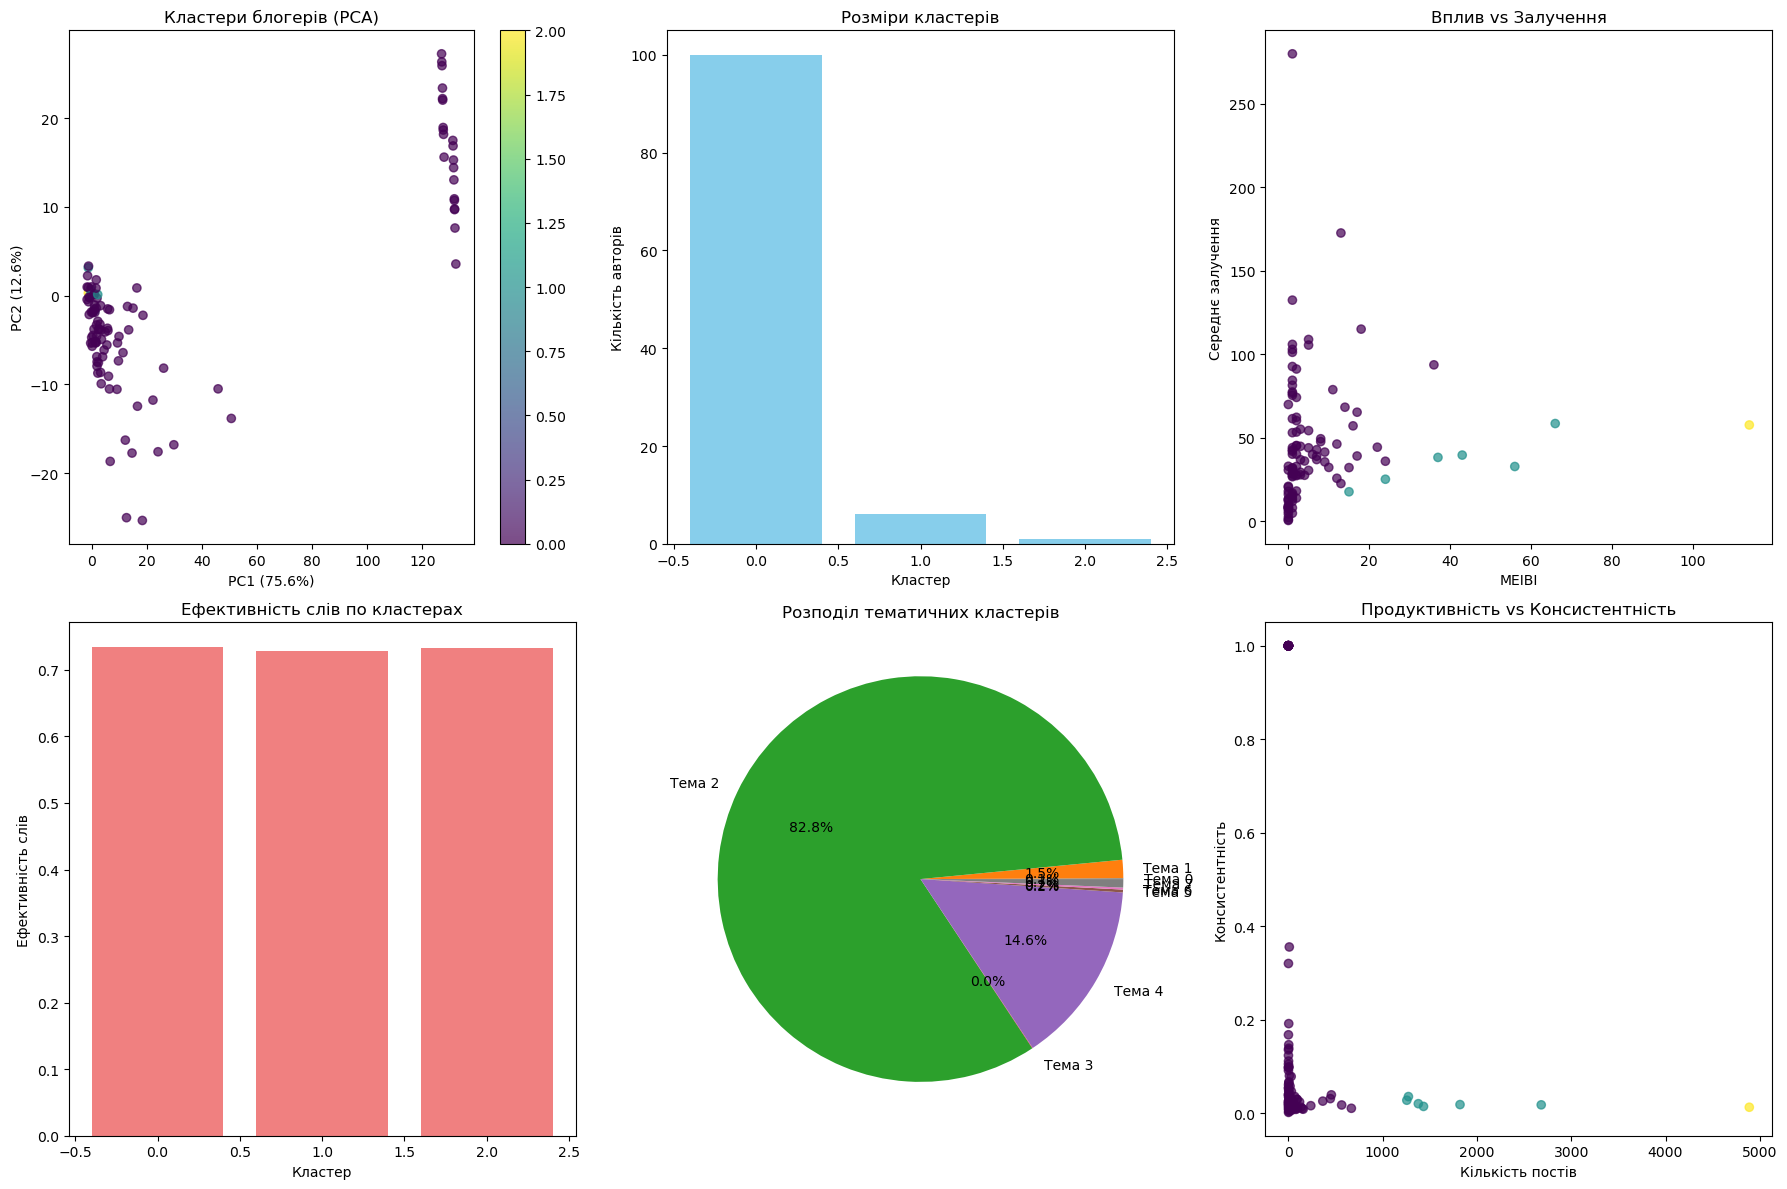


=== ПРИКЛАДИ РЕКОМЕНДАЦІЙ ===

blue point technologies:
  1. Michael Arrington (MEIBI: 114, Залучення: 57.7)
  2. Erick Schonfeld (MEIBI: 56, Залучення: 32.9)
  3. Jason Kincaid (MEIBI: 43, Залучення: 39.7)

call a cab limited:
  1. Michael Arrington (MEIBI: 114, Залучення: 57.7)
  2. MG Siegler (MEIBI: 66, Залучення: 58.6)
  3. Erick Schonfeld (MEIBI: 56, Залучення: 32.9)

nationwide car hire uk ltd:
  1. MG Siegler (MEIBI: 66, Залучення: 58.6)

european biomass association:
  1. Michael Arrington (MEIBI: 114, Залучення: 57.7)
  2. MG Siegler (MEIBI: 66, Залучення: 58.6)
  3. Erick Schonfeld (MEIBI: 56, Залучення: 32.9)

intermedicas worldwide:
  1. Michael Arrington (MEIBI: 114, Залучення: 57.7)
  2. MG Siegler (MEIBI: 66, Залучення: 58.6)
  3. Erick Schonfeld (MEIBI: 56, Залучення: 32.9)


In [14]:
print("\n=== 1. Підготовка даних... ===")
authors_df, companies_df, posts_df, authors_posts_df = prepare_data(authors_df, companies_df, posts_df)

print("\n=== 2. Створення розширених ознак... ===")
enhanced_df = create_enhanced_features(authors_posts_df)

# Ознаки для кластеризації
clustering_features = [
    'meibi', 'meibix', 'word_efficiency', 'influence_quality_ratio',
    'avg_engagement', 'consistency', 'productivity', 'posting_frequency'
]

print("\n=== 3. Кластеризація блогерів... ===")
clustered_df, model, X_scaled, labels, scaler = enhanced_clustering(enhanced_df, clustering_features)

print("\n=== 4. Аналіз тематики контенту... ===")
final_df, topic_keywords = analyze_content_topics(clustered_df)

print("\n=== 5. Детальний аналіз кластерів... ===")
cluster_analysis = analyze_clusters_detailed(final_df)

print("\n=== 6. Створення рекомендацій... ===")
recommendations = intelligent_recommendation_system(
    companies_df, final_df, cluster_analysis, topic_keywords
)
print("\n=== 7. Візуалізація результатів... ===")
create_visualizations(final_df, X_scaled, labels, cluster_analysis)

# Приклад рекомендацій
print("\n=== ПРИКЛАДИ РЕКОМЕНДАЦІЙ ===")
for i, (company, recs) in enumerate(list(recommendations.items())[:5]):
    print(f"\n{company}:")
    for j, rec in enumerate(recs):
        print(f"  {j+1}. {rec[0]} (MEIBI: {rec[1]:.0f}, Залучення: {rec[2]:.1f})")



### Висновки:

- Блогери покривають технологічну нішу
- Основні напрямки: мобільні технології, соціальні мережі, розробка
- Можна створювати тематичні рекомендації для брендів із цих сфер
- Кожен блогер отримає мітку з 1-2 основними темами для точного таргетингу

### Аналіз кластерів:
- **Кластер 0: "Якісний контент" (100 авторів)**  
    Профіль: Стабільні, масові блогери  
    MEIBI: 15.1 - низький індекс впливу (багато авторів з схожими показниками)  
    Залучення: 41.9 - середнє залучення аудиторії  
    Характеристика: Основна маса якісних блогерів зі стабільною аудиторією  

- **Кластер 1: "Початкові блогери" (6 авторів)**  
    Профіль: Перспективні автори  
    MEIBI: 43.0 - високий індекс впливу (рідкісні в своїй ніші)  
    Залучення: 35.7 - трохи нижче середнього  
    Характеристика: Нішеві експерти з унікальним контентом  

- **Кластер 2: "Топ-інфлюенсер" (1 автор - Michael Arrington)**    
    Профіль: Мега-інфлюенсер  
    MEIBI: 114.0 - надвисокий індекс впливу (унікальний)  
    Залучення: 57.7 - найвище залучення  
    Характеристика: Топ-лідер думок у сфері  

### Практичне застосування:
- **Для брендів:**  
    Кластер 0: Масові кампанії, стабільне залучення    
    Кластер 1: Нішевий маркетинг, експертний контент  
    Кластер 2: Преміум-партнерства, максимальний вплив  

- **Ціноутворення:**  
    Кластер 0: стандартні тарифи  
    Кластер 1: підвищені тарифи за унікальність  
    Кластер 2: преміум-тарифи за топ-вплив  